# Housing Days On Market RFECV Feature Selection

## Information

Housing related data sources were combined in the project SQLite database. The output CSV file is analyzed here. 

### Environment Information:

Environment used for coding is as follow:

Oracle VM VirtualBox running Ubuntu (guest) on Windows 10 (host).

Current conda install:

               platform : linux-64
          conda version : 4.2.13
       conda is private : False
      conda-env version : 4.2.13
    conda-build version : 1.20.0
         python version : 2.7.11.final.0
       requests version : 2.9.1
       default environment : /home/jonathan/anaconda2/envs/py35
       
       Python 3.5.2 :: Anaconda 4.1.1 (64-bit)

Package requirements:

dill : 0.2.5, numpy : 1.11.3, pandas : 0.18.1, matplotlib : 1.5.1, scipy : 0.18.1, seaborn : 0.7.1, scikit-image : 0.12.3, scikit-learn : 0.18.1

## Python Package(s) Used

In [1]:
import dill
from itertools import chain
import numpy as np
import pandas as pd
import time

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LassoCV, SGDRegressor, TheilSenRegressor, PassiveAggressiveRegressor, HuberRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
%matplotlib inline

In [5]:
plt.style.use('seaborn-whitegrid')

## Data and Methods

### Data Fetching

In [6]:
# Import data csv into dataframe
df = pd.read_csv('df_prep_for_feature_selection_output.csv')
df = df.drop('Unnamed: 0', axis = 1)
df.head()

,ListPrice2,Bedrooms,BathsFull,BathsHalf,Levels,Fireplaces,BasementY/N,Acres,YearBuilt,DOMP,...,HSSR_1.0,HSSR_2.0,HSSR_3.0,HSSR_4.0,MSSR_0.0,MSSR_1.0,MSSR_2.0,MSSR_3.0,MSSR_4.0,MSSR_5.0
0,269900,3,2,0.0,3,0,1,0.082,1950,10,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,255000,2,2,1.0,2,1,0,0.000,1987,41,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,299900,1,1,0.0,1,0,0,0.000,1941,12,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,245000,1,1,0.0,1,0,0,0.000,1941,16,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,250000,1,1,0.0,1,0,0,0.000,1891,5,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Regression Modelling

### Feature Selection

In [7]:
df_2 = df.copy()

In [8]:
# Performing feature selection on full dataset, resulted in best_score ~ 0.1.
# Qcutting to separate out data.
# qcut value = 1 is dataset as is.

# Qcut DOMP target data
df_2['qcut_DOMP'] = pd.qcut(df_2['DOMP'], 1, labels = False)
# Print out total row counts for each group
print(df_2['qcut_DOMP'].value_counts())
# Select specific range
df_2 = df_2[df_2['qcut_DOMP'] == 0]
# Save dataframe to disk
df_2.to_csv('df_RFECV_feature_selection_qcut_DOMP_1,1_save_point.csv')

0    13725
Name: qcut_DOMP, dtype: int64


In [9]:
# Copy dataframe for dropping columns and determining categorical columns
df_3 = df_2.copy()
# Drop target column and qcut column for test-train-split
df_3 = df_3.drop('DOMP', axis=1)
df_3 = df_3.drop('qcut_DOMP', axis=1)

In [ ]:
# Checking for grouped categorical columns
#df_3.columns[89:]

In [ ]:
# Columns that are not scaled since they are categorical
# cat_df = df_3[[u'BasementY/N']]
# cat_df_2 = df_3.ix[:,34:38]
# cat_df_3 = df_3.ix[:,43:47]
# cat_df_4 = df_3.ix[:,52:56]
# cat_df_5 = df_3.ix[:,93:178]
# cat_df_6 = pd.concat([cat_df,cat_df_2,cat_df_3,cat_df_4,cat_df_5],axis=1)
# CATEGORICAL = [x for x in cat_df_6.columns]
# CATEGORICAL

In [10]:
CATEGORICAL = ['BasementY/N','ES_IsTitleI','HS_IsTitleI','MS_IsTitleI','zip_20001',
               'zip_20002','zip_20004','zip_20005','zip_20007','zip_20008','zip_20009',
               'zip_20010','zip_20011','zip_20012','zip_20015','zip_20017','zip_20018',
               'zip_20019','zip_20020','zip_20032','zip_20036','zip_20037','ldmonth_1',
               'ldmonth_2','ldmonth_3','ldmonth_4','ldmonth_5','ldmonth_6','ldmonth_7',
               'ldmonth_8','ldmonth_9','ldmonth_10','ldmonth_11','ldmonth_12','ldday_1',
               'ldday_2','ldday_3','ldday_4','ldday_5','ldday_6','ldday_7','ldday_8',
               'ldday_9','ldday_10','ldday_11','ldday_12','ldday_13','ldday_14','ldday_15',
               'ldday_16','ldday_17','ldday_18','ldday_19','ldday_20','ldday_21','ldday_22',
               'ldday_23','ldday_24','ldday_25','ldday_26','ldday_27','ldday_28','ldday_29',
               'ldday_30','ldday_31','ESSR_0.0','ESSR_1.0','ESSR_2.0','ESSR_3.0','ESSR_4.0',
               'ESSR_5.0','HSSR_0.0','HSSR_1.0','HSSR_2.0','HSSR_3.0','HSSR_4.0','MSSR_0.0',
               'MSSR_1.0','MSSR_2.0','MSSR_3.0','MSSR_4.0','MSSR_5.0']

In [11]:
def RFECV_feature_selection(df,feature_model,feature_model_str,eps_str,CATEGORICAL,qcut_DOMP_str):

    """
    Use RFECV for feature selection using estimator. LassoCV and SGDRegressor chosen as the 
    primary estimators due to processing time and choice in loss functions and penalties.
    The function here test-train-splits the dataset, and performs modelling with RFECV.
    Output models are saved as as dills, and the optimum number of features is determined.
    """
    
    # Start clock for run time
    start  = time.time()
    
    # Copy dataframe
    df_2 = df.copy()
    
    # Drop target column and qcut column for test-train-split
    df_2 = df_2.drop('DOMP', axis=1)
    df_2 = df_2.drop('qcut_DOMP', axis=1)
    
    # Test-train split. Using 70/30% split.
    X_train, X_test, y_train, y_test = train_test_split(df_2, df['DOMP'], train_size=0.70,
                                                    random_state=1)    
    
    # Standardizing training and testing data. Standardized separately to avoid information
    # leaking from the training set to the testing set. Categorical data not scaled.
    for i in X_train.columns.difference(CATEGORICAL):
        X_train[i] = StandardScaler().fit_transform(X_train[i].values.reshape(-1,1))

    for i in X_test.columns.difference(CATEGORICAL):
        X_test[i] = StandardScaler().fit_transform(X_test[i].values.reshape(-1,1))  
    
    # Initialize RFECV and fit model
    rfecv = RFECV(feature_model, step=1, cv=4, verbose=False)
    rfecv.fit(X_train, y_train)    
    
    # Save model to disk
    dill.dump(rfecv, open('RFECV_feature_selection_'+feature_model_str+'_eps_'+eps_str+'_qcut_'+qcut_DOMP_str, 'wb'))
    #dill.dump(refcv.best_estimator_, open('RFECV_feature_selection_'+feature_model_str+'_best_model_estimator_', 'wb'))

    # Print optimal number of features
    print("Optimal number of features : %d" % rfecv.n_features_)
    
    # Print run time
    print("\nBuild and Validation took {:0.3f} seconds\n".format(time.time()-start))   

In [12]:
RFECV_feature_selection(df_2,LassoCV(eps=0.001,max_iter=50000,cv=4,random_state=1),'LCV','0001',CATEGORICAL,'1,1')
RFECV_feature_selection(df_2,LassoCV(eps=0.01,max_iter=50000,cv=4,random_state=1),'LCV','001',CATEGORICAL,'1,1')
RFECV_feature_selection(df_2,LassoCV(eps=0.1,max_iter=50000,cv=4,random_state=1),'LCV','01',CATEGORICAL,'1,1')

/home/jonathan/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jonathan/anaconda2/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/home/jonathan/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Optimal number of features : 122

Build and Validation took 401.496 seconds



/home/jonathan/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jonathan/anaconda2/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/home/jonathan/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Optimal number of features : 44

Build and Validation took 214.526 seconds



/home/jonathan/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jonathan/anaconda2/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/home/jonathan/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Optimal number of features : 123

Build and Validation took 124.891 seconds



In [13]:
def plot_RFECV_score_vs_features(df,feature_model_str,eps_str,qcut_DOMP_str):
    # Import dill file of model
    model = dill.load(open('RFECV_feature_selection_'+feature_model_str+'_eps_'+eps_str+'_qcut_'+qcut_DOMP_str, 'rb'))
     
    # Plot number of features vs. cross-validation scores
    plt.figure()
    plt.plot(range(1, len(model.grid_scores_) + 1), model.grid_scores_,linewidth=3)
    plt.title('CV score vs features',fontsize=18,fontweight='bold')
    plt.xlabel("Number of features selected",fontsize=14,fontweight='bold')
    plt.xticks(fontsize=14,fontweight='bold')
    plt.ylabel("Cross validation score",fontsize=14,fontweight='bold')
    plt.yticks(fontsize=14,fontweight='bold')
    plt.legend(fontsize=16)
    plt.savefig('RFECV_feature_selection_'+feature_model_str+'_eps_'+eps_str+'_qcut_'+qcut_DOMP_str+'_plot_score_vs_features')
    plt.show()
    
    # Print out table of sorted features by importance.
    print("Features sorted: ")
    rfecv_ranking_df = pd.DataFrame({'feature':df.columns,
                                     'importance':model.ranking_})
    rfecv_ranking_df_sorted = rfecv_ranking_df.sort_values(by = 'importance'
                                        , ascending = True)
    rfecv_ranking_df_sorted.to_csv('RFECV_feature_selection_'+feature_model_str+'_eps_'+eps_str+'_qcut_'+qcut_DOMP_str+'_feature_importances.csv')
    print(rfecv_ranking_df_sorted.head(10))

/home/jonathan/anaconda2/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


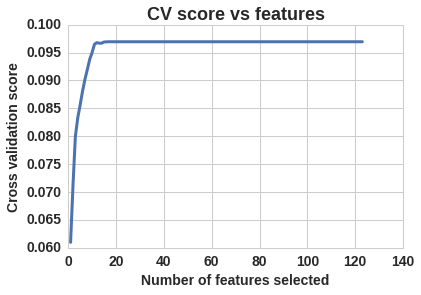

Features sorted: 
       feature  importance
0   ListPrice2           1
89    ldday_15           1
88    ldday_14           1
87    ldday_13           1
86    ldday_12           1
85    ldday_11           1
84    ldday_10           1
83     ldday_9           1
82     ldday_8           1
81     ldday_7           1


In [16]:
plot_RFECV_score_vs_features(df_3,'LCV','01','1,1')

In [ ]:
# SGDRegressor with loss = epsilon_insensitive produces the best results of the selected
# parameters. This also takes into account that the CV scores are still around zero.
# The important features change little with the penalty used, with a core group of
# features common for all three penalties. 

def create_combined_important_features_subset_dataframe(feature_model_str,eps_str_1,eps_str_2,eps_str_3):
    # Import data into dataframes
    df_features_1 = pd.read_csv('RFECV_feature_selection_'+feature_model_str+'_eps_'+eps_str_1+'_feature_importances.csv')
    df_features_2 = pd.read_csv('RFECV_feature_selection_'+feature_model_str+'_eps_'+eps_str_2+'_feature_importances.csv')
    df_features_3 = pd.read_csv('RFECV_feature_selection_'+feature_model_str+'_eps_'+eps_str_3+'_feature_importances.csv')

    # Subset dataframes on most important features
    df_features_1 = df_features_1[df_features_1['importance'] == 1]
    df_features_2 = df_features_2[df_features_2['importance'] == 1]
    df_features_3 = df_features_3[df_features_3['importance'] == 1]

    # Create lists of feature names from dataframes
    df_features_1_lst = [x for x in df_features_1['feature']]
    df_features_2_lst = [x for x in df_features_2['feature']]
    df_features_3_lst = [x for x in df_features_3['feature']]

    # Create combined list of feature names
    df_feature_lst = []
    df_feature_lst = list(chain(df_features_1_lst,df_features_2_lst,df_features_3_lst))
    df_feature_lst = list(set(df_feature_lst))

    # Subset dataframe with most important features
    df_4 = df_2[df_feature_lst]
    df_4['DOMP'] = df_2['DOMP']
    df_4['qcut_DOMP'] = df_2['qcut_DOMP']

    # Save dataframe to disk
    df_4.to_csv('df_RFECV_feature_selection_'+feature_model_str+'_combined_output.csv')

In [ ]:
create_combined_important_features_subset_dataframe('LCV','0001','001','01')

In [ ]:
# Subset data based on important features and save to disk

def create_important_features_subset_dataframe(feature_model_str,eps_str):
    # Import data into dataframes
    df_features_1 = pd.read_csv('RFECV_feature_selection_'+feature_model_str+'_eps_'+eps_str+'_feature_importances.csv')
   
    # Subset dataframes on most important features
    df_features_1 = df_features_1[df_features_1['importance'] == 1]
    
    # Create lists of feature names from dataframes
    df_features_1_lst = [x for x in df_features_1['feature']]
    
    # Subset dataframe with most important features
    df_4 = df_2[df_features_1_lst]
    df_4['DOMP'] = df_2['DOMP']
    df_4['qcut_DOMP'] = df_2['qcut_DOMP']

    # Save dataframe to disk
    df_4.to_csv('df_RFECV_feature_selection_'+feature_model_str+'_eps_'+eps_str+'_output.csv')

In [ ]:
create_important_features_subset_dataframe('LCV','01')